In [1]:
try:
  import shap
except ModuleNotFoundError:
  !pip install shap
  import shap


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.pyplot import cm
import matplotlib.colors as colors
import cycler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import itertools
import math
import matplotlib.colors as mcolors

# set plotting parameters from the beginning
font = {'family' : 'monospace',
        'weight' : 'normal',
        'size'   : 14}
axes = {
        'titlesize' : 20,
        'labelsize' : 18}
figure = {'figsize':(6,4),
         'autolayout':True}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rc('figure', **figure)

# Understanding SHAP values



Let's take the case of three features $\mathbf{M} = \{x_1, x_2, x_3\}$, with $M = |\mathbf{M}| = 3$.

The Shapley value for any given feature $x_k$ is given by
$$
\varphi(x_k) = \frac{1}{M} \sum_{S \subset \mathbf{M} \setminus \{x_k\}} {M-1 \choose |S|}^{-1} \left(F_{S \bigcup \{x_k\}} - F_S \right)
$$

Let's compute the Shapley value for the third feature.  It's easier if we start by arranging everything in a table.  The rows of the table correspond to teach subset that excludes the third feature:
$$
\left\{\emptyset, \{x_1\}, \{x_2\}, \{x_1, x_2 \} \right\}
$$


$$
\begin{array}{|c|c|c|}
\hline
 & \text{Weight} \hspace{2mm} {M-1 \choose |S|}^{-1} & \text{Contribution} \\
\hline
\emptyset & 1 & F_3 - F_{\emptyset} \\
\hline
\{x_1\} & 1/2 & F_{1,3} - F_{1} \\
\hline
\{x_2\} & 1/2 & F_{2,3} - F_{2} \\
\hline
\{x_1, x_2\} & 1 & F_{1,2,3} - F_{1,2} \\
\hline
\end{array}
$$

So the Shapley value for $x_3$ is

$$
\begin{eqnarray}
\varphi(x_1) &=& \frac{1}{3}\left((F_1 - F_{\emptyset}) +  \frac{1}{2}(F_{1,2} - F_{2}) +  \frac{1}{2}(F_{1,3} - F_{3}) + (F_{1,2,3} - F_{2,3})\right) \\
\varphi(x_2) &=& \frac{1}{3}\left((F_2 - F_{\emptyset}) +  \frac{1}{2}(F_{1,2} - F_{1}) +  \frac{1}{2}(F_{2,3} - F_{3}) + (F_{1,2,3} - F_{1,3})\right) \\
\varphi(x_3) &=& \frac{1}{3}\left((F_3 - F_{\emptyset}) +  \frac{1}{2}(F_{1,3} - F_{1}) +  \frac{1}{2}(F_{2,3} - F_{2}) + (F_{1,2,3} - F_{1,2})\right) \\
\end{eqnarray}
$$

You can rearrange and check that it simplifies very nicely.
$$
\sum \varphi(x_k) = F_{1,2,3} - F_{\emptyset} \Longleftrightarrow F(x_1, x_2, x_3) = F_{\emptyset} + \sum \varphi(x_k)
$$

Alternatively:

$$
\text{Individual prediction} = \text{Base value}  + \text{SUM(contributions)}
$$

Text(0, 0.5, 'Number of subsets')

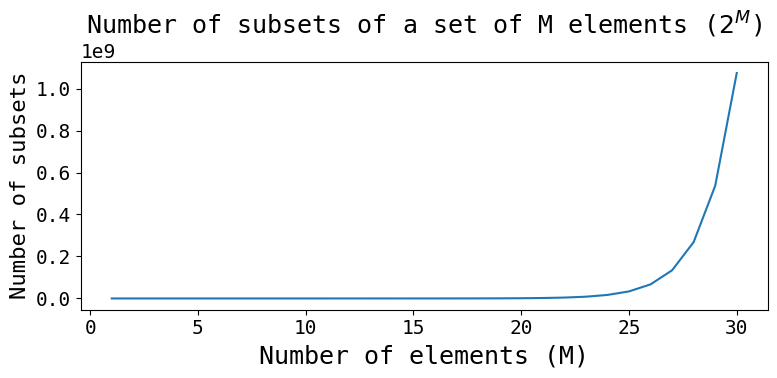

In [3]:
# let's show exponential growth: 2^M
# {x1} -> There's only one subset that excludes x1 (null set): 2^0 = 1
# {x1,x2} --> There are two subsets that exclud x1 (null + {x2}): 2^1 = 2
# {x1,x2,x3} --> We already saw that we have {null, {x2}, {x3}, {x2,x3}}: 2^2 = 4
M = 30
grid = list(range(1,M+1))
powerset = [2**m for m in grid]
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(grid, powerset)
ax.set_title(r'Number of subsets of a set of M elements ($2^M$)', fontsize=18)
ax.set_xlabel('Number of elements (M)')
ax.set_ylabel('Number of subsets',fontsize=16)

### Let's calculate Shapley values now

In [4]:
def simulate_model_simple(parameters, nobs, seed):
  "Function to simulate a linear model"
  vars_x = [var for var in parameters.keys() if var.find('x')>=0]
  xdf = pd.DataFrame(columns = vars_x, index = range(nobs))
  ydf = pd.DataFrame([0]*nobs, columns=['y'], index = range(nobs))
  for var in vars_x:
    mv = parameters[var]['mean']
    sv = parameters[var]['var']
    parv = parameters[var]['param']
    prev = mv + np.sqrt(sv)*np.random.randn(nobs)
    xdf[var] = prev
    ydf.y += parv*prev
  # finally the residual
  resids = parameters['eps']['mean'] + np.sqrt(parameters['eps']['var'])*np.random.randn(nobs)
  ydf.y += resids
  return ydf, xdf

ptest = {'x0':{'mean':1, 'var':0, 'param':1},
         'x1':{'mean':1, 'var':0, 'param':2},
         'eps':{'mean':0, 'var':0, 'param':1},}
test = simulate_model_simple(parameters = ptest, nobs=2, seed=1)
test[0], test[1]

(     y
 0  3.0
 1  3.0,
     x0   x1
 0  1.0  1.0
 1  1.0  1.0)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


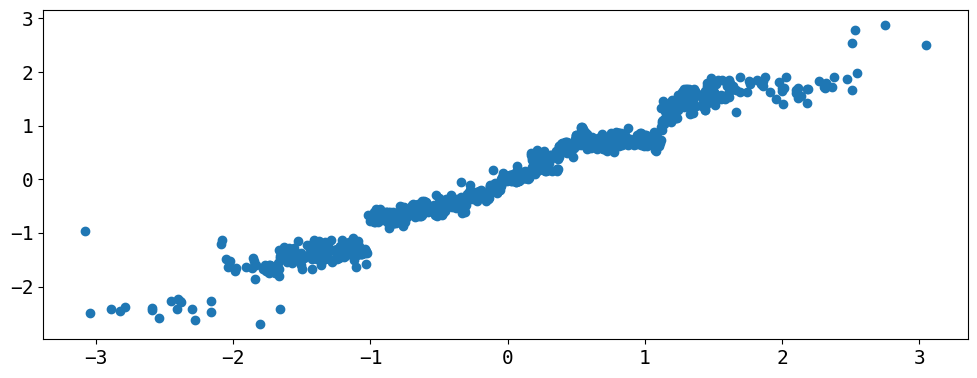

In [5]:
# test model
nobs = 1000
seed = 1234
params = {'x0': {'mean':1, 'var':0, 'param':10},
          'x1': {'mean':0, 'var':1, 'param':1},
          'x2': {'mean':0, 'var':1, 'param':-1},
          'x3': {'mean':0, 'var':1, 'param':1},
          'eps': {'mean':0, 'var':2, 'params':1}}
ydf, xdf = simulate_model_simple(parameters = params, nobs = nobs, seed = seed)
xdf = xdf[xdf.columns[xdf.columns != 'x0']]  # for training purposes I don't need the constant

gbr = GradientBoostingRegressor(random_state=1089, max_depth = 2)
gbr.fit(xdf,ydf.values)
explainer = shap.TreeExplainer(gbr, xdf)
shap_values = explainer(xdf)
#splt = shap.plots.waterfall(shap_values[unit_chosen])
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(xdf.values[:,0], shap_values.values[:,0])



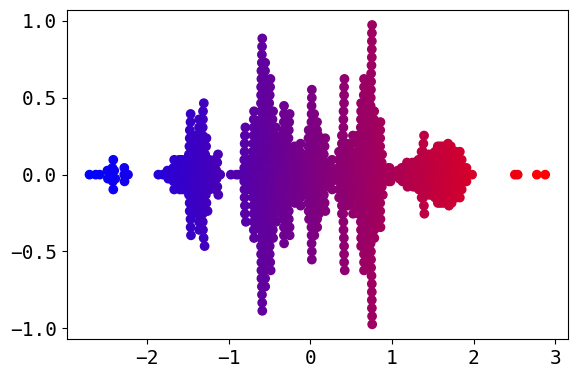

In [6]:
def simple_beeswarm(y, nbins=None):
  "Function to recreate SHAPs beeswarm plot"
    y = np.asarray(y)
    if nbins is None:
        nbins = len(y) // 6
    x = np.zeros(len(y))
    ylo = np.min(y)
    yhi = np.max(y)
    dy = (yhi - ylo) / nbins
    ybins = np.linspace(ylo + dy, yhi - dy, nbins - 1)
    i = np.arange(len(y))
    ibs = [0] * nbins
    ybs = [0] * nbins
    nmax = 0
    for j, ybin in enumerate(ybins):
        f = y <= ybin
        ibs[j], ybs[j] = i[f], y[f]
        nmax = max(nmax, len(ibs[j]))
        f = ~f
        i, y = i[f], y[f]
    ibs[-1], ybs[-1] = i, y
    nmax = max(nmax, len(ibs[-1]))
    dx = 1 / (nmax // 2)
    for i, y in zip(ibs, ybs):
        if len(i) > 1:
            j = len(i) % 2
            i = i[np.argsort(y)]
            a = i[j::2]
            b = i[j+1::2]
            x[a] = (0.5 + j / 3 + np.arange(len(b))) * dx
            x[b] = (0.5 + j / 3 + np.arange(len(b))) * -dx

    return x


testx = shap_values.values[:,0]
testy = simple_beeswarm(testx)
cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "red"])
norm = plt.Normalize(vmin=np.min(testx), vmax=np.max(testx))
plt.scatter(testx, testy, c=testx, cmap=cmap, norm=norm)


In [7]:
def rescale(x, a, b, c, d):
    return c + ((d - c) * (x - a)) / (b - a)

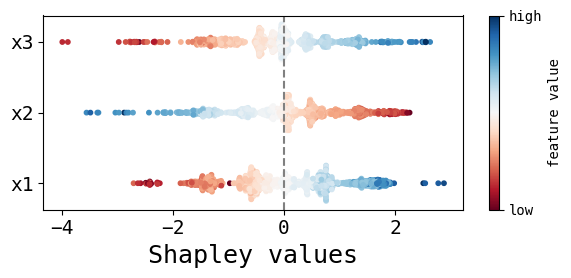

In [8]:
def my_beeswarm_plot(shap_df, xdf, ax):
  "Like SHAPs one, this rescales things and plots all features"
  #cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue", "red"])
  cmap=plt.get_cmap("RdBu")
  for i,col in enumerate(shap_df.columns):
    fi = xdf[col]
    xi = shap_df[col]
    yi = simple_beeswarm(xi)
    # I need to rescale y
    yi = rescale(yi, np.min(yi), np.max(yi),0,1)
    norm = plt.Normalize(vmin=np.min(fi), vmax=np.max(fi))
    scatter = ax.scatter(xi, 2*i+yi, c=fi, cmap=cmap, norm=norm, s=10, alpha=1)

  #xtl = ax.set_xticklabels('')
  #xt = ax.set_xticks([])
  yt = ax.set_yticks([2*i + 0.5 for i in range(3)])
  ytl = ax.set_yticklabels(shap_df.columns)
  ymin, ymax = ax.get_ylim()
  ax.plot([0,0], [ymin, ymax], ls='--', color='0.5')
  ax.set_ylim([ymin, ymax])
  ax.set_xlabel('Shapley values')
  cbar = plt.colorbar(scatter)
  cbar.set_ticks([np.min(fi), np.max(fi)])
  cbar.set_ticklabels(["low", "high"], fontsize=10)
  cbar.set_label('feature value', rotation=90, fontsize=10)
  return ax

# test the function
fig, ax = plt.subplots(figsize = (6,3))
shap_df = pd.DataFrame(shap_values.values, columns = xdf.columns)
ax = my_beeswarm_plot(shap_df, xdf, ax=ax)

Text(0.5, 1.0, 'Local Summary')

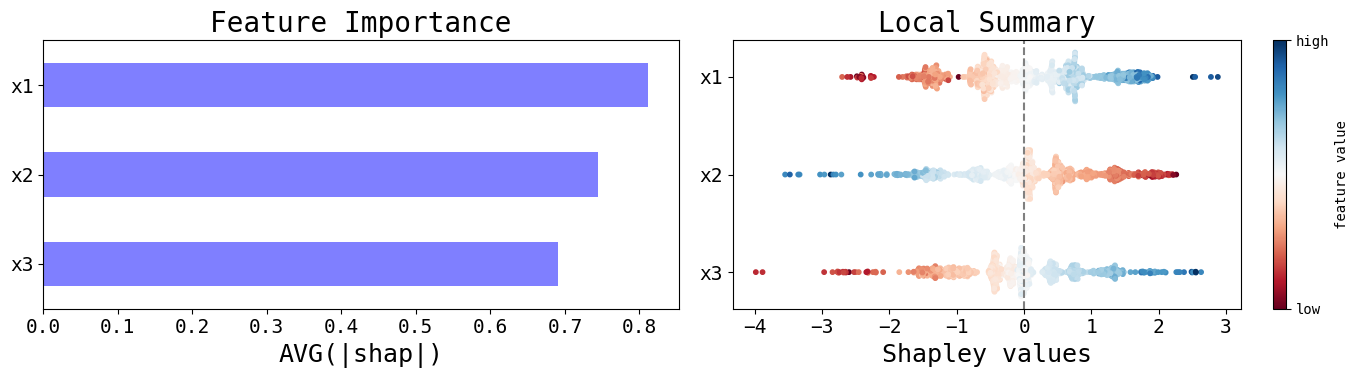

In [9]:
# calculate feature importances as the mean of abs(shap_values)
feat_importance = pd.DataFrame(np.mean(np.abs(shap_values.values), axis=0), index= ['x1','x2','x3'], columns = ['feat_importance'])
feat_importance.sort_values(by='feat_importance', ascending=True, inplace=True)
fig, ax = plt.subplots(1,2, figsize=(14,4))
feat_importance.plot(kind='barh', ax=ax[0], color='b', alpha=0.5)
ax[0].get_legend().remove()
ax[0].set_title(r'Feature Importance')
ax[0].set_xlabel('AVG(|shap|)')
# second plot will have individual shapley values
shap_df = shap_df[feat_importance.index]
axi = my_beeswarm_plot(shap_df, xdf, ax=ax[1])
ax[1].set_title('Local Summary')

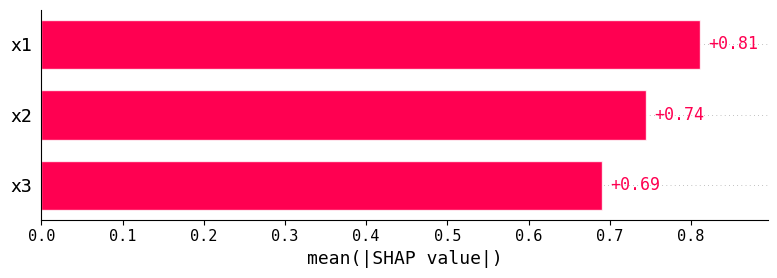

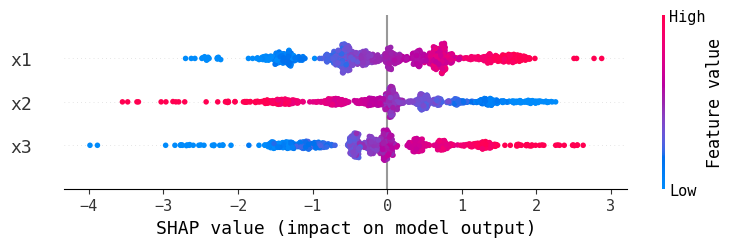

In [10]:
# Compare with SHAP library
shap.plots.bar(shap_values)

shap.plots.beeswarm(shap_values)

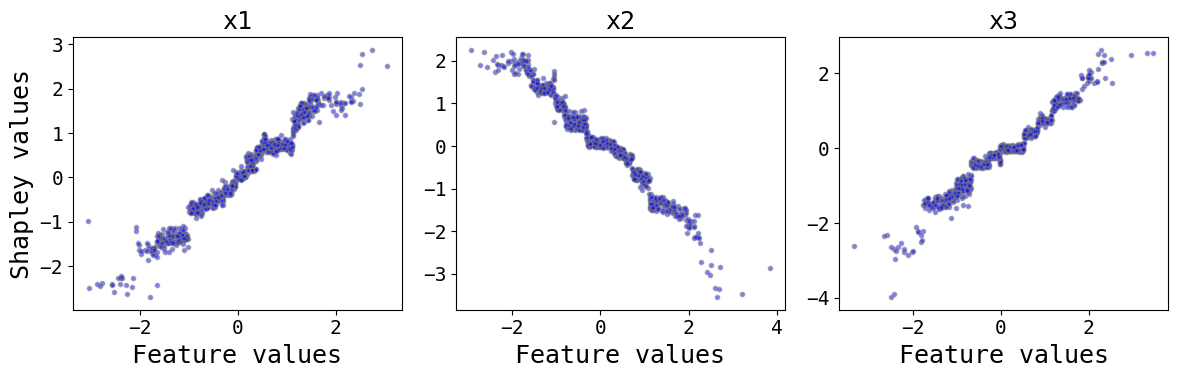

In [11]:
# finally, let's get something similar to a PDP
ix_neg = xdf['x2'].idxmin()
fig, ax = plt.subplots(1,3, figsize=(12,4),sharey=False)
for i, col in enumerate(xdf.columns):
  ax[i].scatter(xdf[col],shap_df[col], s=10, edgecolor='0.5', alpha=0.5, color='b')
  #ax[i].scatter(xdf[col].loc[ix_neg],shap_df[col].loc[ix_neg], s=40, color='r', edgecolor='k')

  ax[i].set_title(col, fontsize = 18)
  if i==0:
    ax[i].set_ylabel('Shapley values')
  ax[i].set_xlabel('Feature values')

In [12]:
def create_shap_explanation(parameters, nobs, seed, simu_mod=simulate_model_simple):
  """
  This function (1) simulates a dataset, (2) Trains a GBR, (3) Prints some statistics
  (4) Calculates SHAP values, (5) plots individual shap values, plots scatter of x and
  shap values, averages shap values to get feature importance
  """
  # 1. Simulate model and split, and drop the intercept
  ydf, xdf = simu_mod(parameters, nobs, seed)
  xdf = xdf.drop('x0', axis=1)
  x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, random_state=2127)
  y_train_a = y_train.y.values
  # 2. Train model
  gbr = GradientBoostingRegressor(random_state=1089, max_depth = 2)
  gbr.fit(x_train,y_train_a)
  # 3. Shap values
  explainer = shap.TreeExplainer(gbr, x_test)
  shap_values = explainer(x_test)
  splt = shap.plots.waterfall(shap_values[0])
  shap_df = pd.DataFrame(shap_values.values, columns = xdf.columns)
  # 4. feature importance & beeswarm
  feat_importance = pd.DataFrame(np.mean(np.abs(shap_values.values), axis=0), index= ['x1','x2','x3'], columns = ['feat_importance'])
  feat_importance.sort_values(by='feat_importance', ascending=True, inplace=True)
  fig, ax = plt.subplots(1,2, figsize=(14,4))
  feat_importance.plot(kind='barh', ax=ax[0], color='b', alpha=0.5)
  ax[0].get_legend().remove()
  ax[0].set_title(r'Feature Importance')
  ax[0].set_xlabel('AVG(|shap|)')
  # second plot will have individual shapley values
  shap_df = shap_df[feat_importance.index]
  axi = my_beeswarm_plot(shap_df, x_test, ax=ax[1])
  ax[1].set_title('Local Summary')
  # 5. A summary with the scatters and feat importance
  fig, ax = plt.subplots(1,4, figsize=(18,4))
  for i, col in enumerate(xdf.columns):
    ax[i].scatter(x_test[col],shap_df[col], s=10, edgecolor='0.5', alpha=0.5, color='b')
    ax[i].set_title(col, fontsize = 18)
    if i==0:
      ax[i].set_ylabel('Shapley values')
    ax[i].set_xlabel('Feature values')
    # plot real model
    gi = np.linspace(x_test[col].min(), x_test[col].max(),5)
    yx = parameters[col]['param'] * gi
    ax[i].plot(gi,yx, color='k', alpha=0.5)
  feat_importance.plot(kind='barh', ax=ax[3], color='b', alpha=0.5)
  ax[3].get_legend().remove()
  ax[3].set_title(r'Feature Importance', fontsize=18)
  ax[3].set_xlabel('AVG(|shap|)', fontsize=16)


  return

#### What should we expect

* We have normalized and independent features
* Each std. deviation of:
  * `x3`: increases `y` by 2
  * `x2/x1`: increases `y` by 1
* For this unit to go from `11.93` to `9.94`
  * Decrease x3

#### SHAP values

In general:

$$
f(x) = E(f(x)) + SUM(\text{contributions})
$$

With linear models this simplifies to

$$
f(x) = f(E(x)) + SUM(\beta_k x_k)
$$

## Let's try alternative models

* **Model 1**: slopes = 1, variances = 1
* **Model 2**: slopes(1,2) = 1 & slope(3) = 2, variances = 1
* **Model 3**: slopes = 1, variances(1,2) = 1, variance(3) =1

In [13]:
xdf.sample(n=len(xdf), replace=True, axis =0).mean()

x1    0.076737
x2   -0.001266
x3    0.037273
dtype: float64

In [14]:
def compute_ci_shaps(xdf, model, num_simu=100):
  "Bootstrap confidence intervals for shapley values"
  nobs = len(xdf)
  feats = len(xdf.columns)
  boot_df = pd.DataFrame(index=range(num_simu), columns=xdf.columns, dtype='float')
  for b in range(num_simu):
    # bootstrap values
    xdf_b = xdf.sample(n=len(xdf), replace=True, axis =0)
    exp_b = shap.TreeExplainer(gbr, xdf_b)
    shap_b = explainer(xdf_b)
    # feature importance
    fib = np.mean(np.abs(shap_b.values), axis=0)
    boot_df.loc[b] = fib
    mean = boot_df.mean()
    qi = boot_df.quantile([0.05, 0.95])
  return mean, qi

test = compute_ci_shaps(xdf, model=gbr, num_simu=5)
test[1]

,x1,x2,x3
0.05,0.795264,0.729540,0.677302
0.95,0.826252,0.760404,0.702406


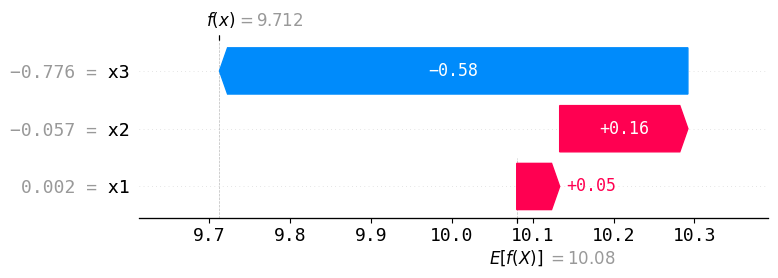

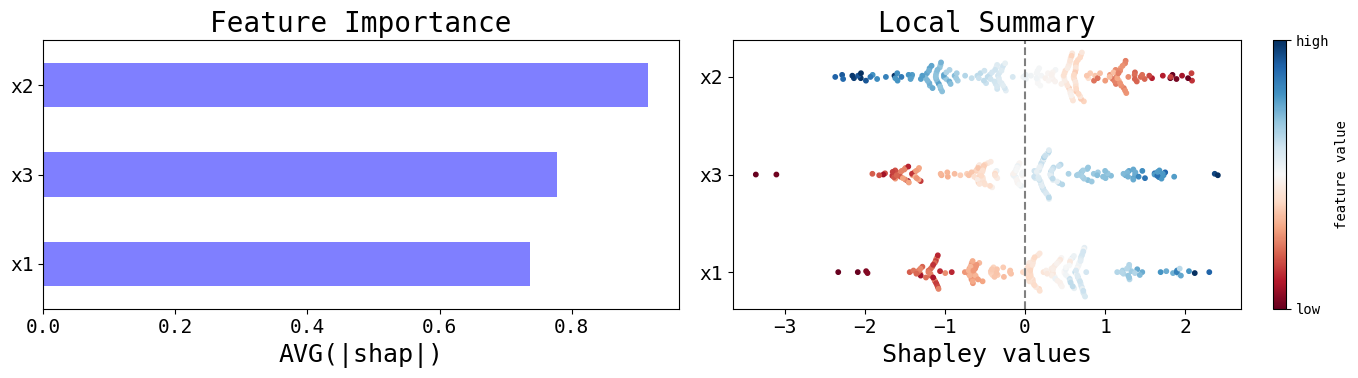

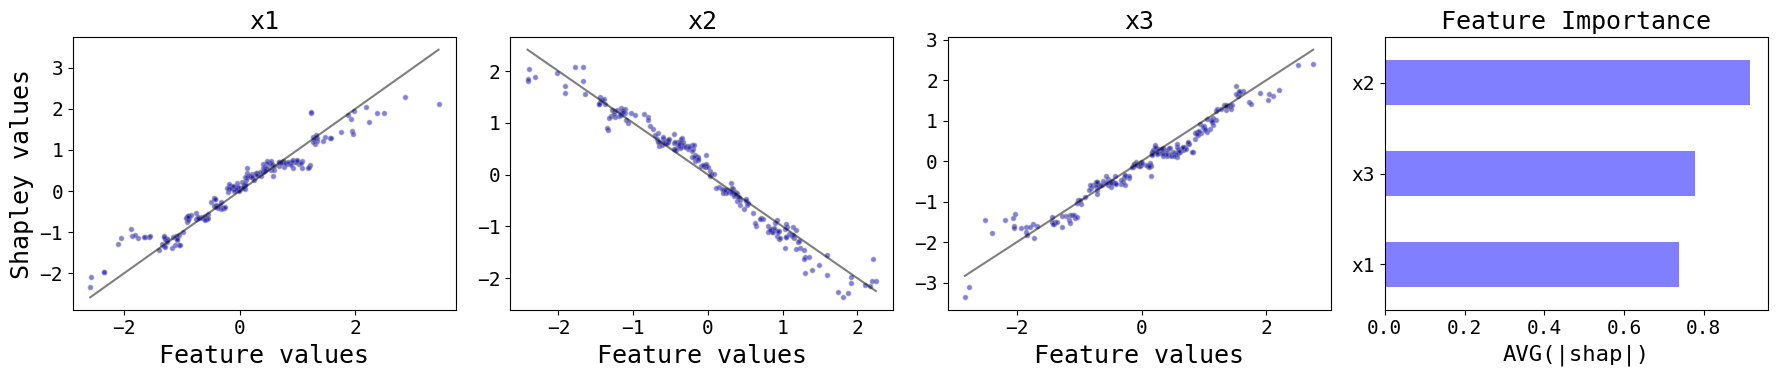

In [15]:
# all Xs are equally important
nobs = 1000
seed = 1234
params0 = {'x0': {'mean':1, 'var':0, 'param':10},
          'x1': {'mean':0, 'var':1, 'param':1},
          'x2': {'mean':0, 'var':1, 'param':-1},
          'x3': {'mean':0, 'var':1, 'param':1},
          'eps': {'mean':0, 'var':2, 'params':1}}

splt = create_shap_explanation(parameters=params0, nobs=nobs, seed=seed)

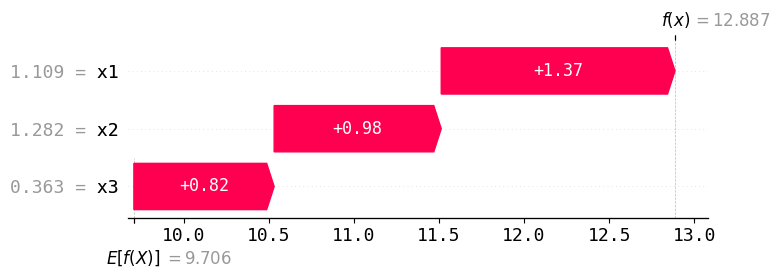

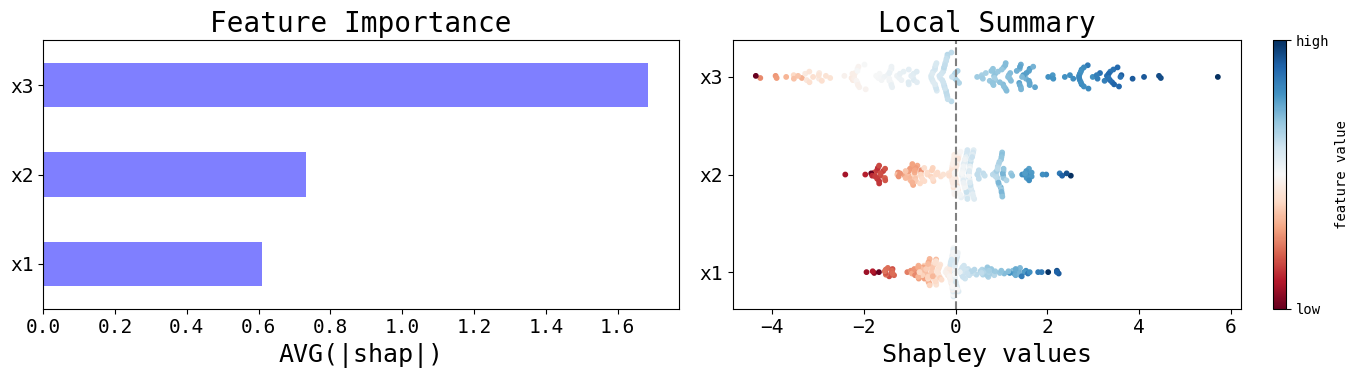

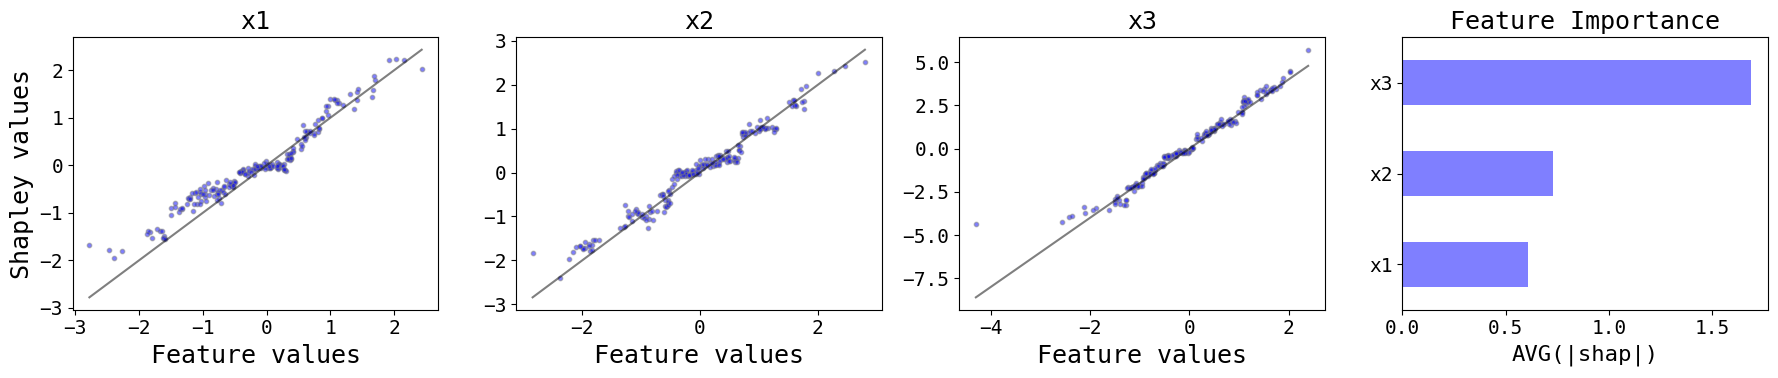

In [16]:
# PARAM(x3) twice as large
seed = 1000
params0 = {'x0': {'mean':1, 'var':0, 'param':10},
          'x1': {'mean':0, 'var':1, 'param':1},
          'x2': {'mean':0, 'var':1, 'param':1},
          'x3': {'mean':0, 'var':1, 'param':2},
          'eps': {'mean':0, 'var':2, 'params':1}}

splt = create_shap_explanation(parameters=params0, nobs=nobs, seed=seed)

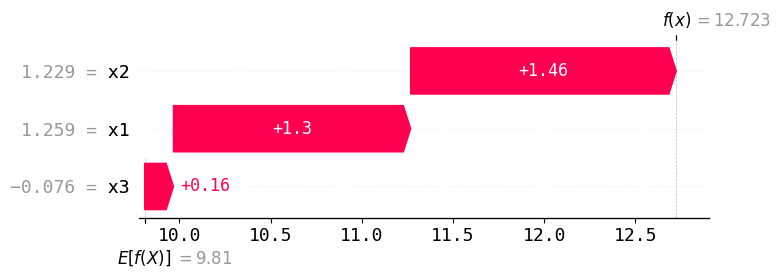

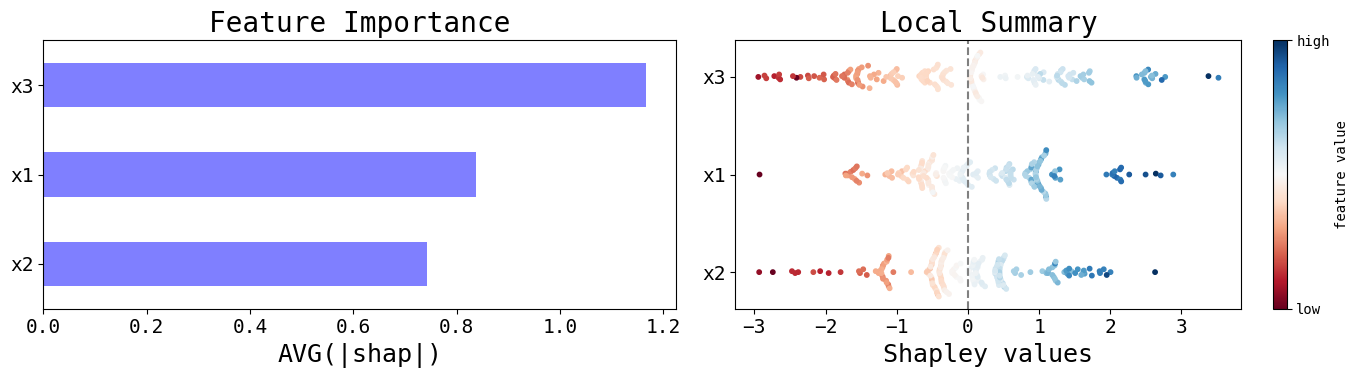

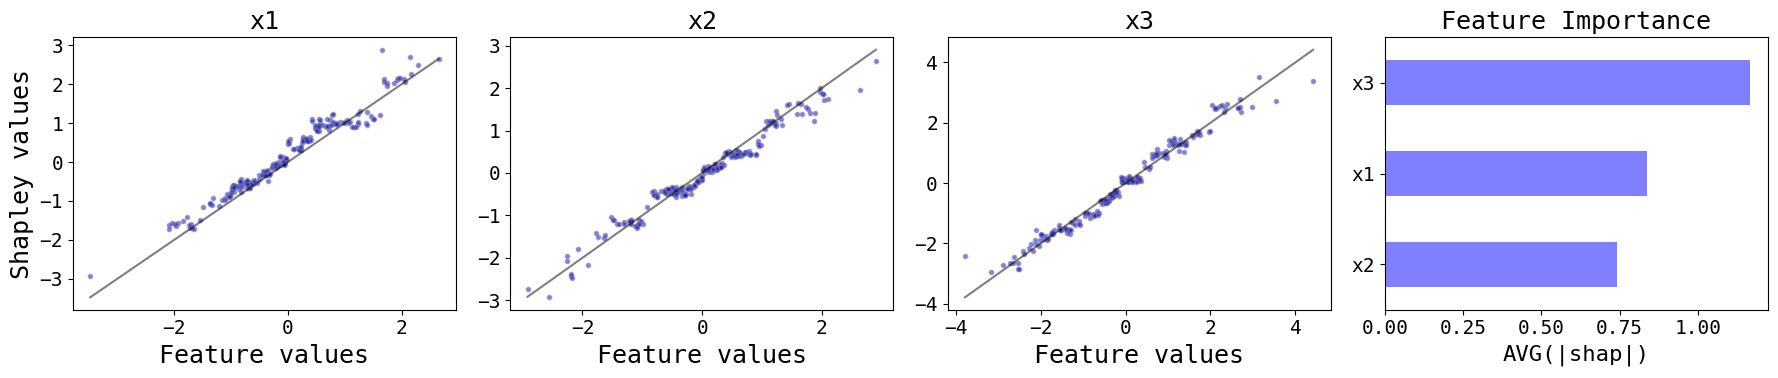

In [17]:
# Double the variance
seed = 1000
params0 = {'x0': {'mean':1, 'var':0, 'param':10},
          'x1': {'mean':0, 'var':1, 'param':1},
          'x2': {'mean':0, 'var':1, 'param':1},
          'x3': {'mean':0, 'var':2, 'param':1},
          'eps': {'mean':0, 'var':2, 'params':1}}

splt = create_shap_explanation(parameters=params0, nobs=nobs, seed=seed)

### Now let's simulate something a bit more complex

$$
\begin{eqnarray}
x_3 &=& \beta_0 + \beta_1 x_2 + \eta \\
y &=& \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \alpha_3 x_3 + \epsilon
\end{eqnarray}
$$

In [18]:
params_ind = {'x0': {'mean': 1, 'var': 0, 'param': 10},
 'x1': {'mean': 0, 'var': 1, 'param': 1},
 'x2': {'mean': 0, 'var': 1, 'param': 1},
 'x3': {'inter': 0, 'slope': 1, 'var_res': 2, 'param':1},
 'eps': {'mean': 0, 'var': 2}}

In [19]:
def simulate_model_indirect(parameters, nobs, seed):
  "Simulate a model with direct and indirect effects"
  vars_x = [var for var in parameters.keys() if var.find('x')>=0]
  xdf = pd.DataFrame(columns = vars_x, index = range(nobs))
  ydf = pd.DataFrame([0]*nobs, columns=['y'], index = range(nobs)) # start: y=0
  for var in vars_x:
    if var != 'x3':
      mv = parameters[var]['mean']
      sv = parameters[var]['var']
      parv = parameters[var]['param']
      prev = mv + np.sqrt(sv)*np.random.randn(nobs)
      xdf[var] = prev
    else:
      a = parameters[var]['inter']
      b = parameters[var]['slope']
      v = parameters[var]['var_res']
      prev = a + b*xdf['x2'].values.flatten() + np.sqrt(v)*np.random.randn(nobs)
      parv = parameters[var]['param']
    xdf[var] = prev
    ydf.y += parv*prev  # update: y=y+beta*x
  # finally the residual
  resids = parameters['eps']['mean'] + np.sqrt(parameters['eps']['var'])*np.random.randn(nobs)
  ydf.y += resids
  return ydf, xdf

# test: x0=0, x1=0, x2 = 1, x3 = 0 + 5*x2 + eps(0) = 5
params_ind = {'x0': {'mean': 1, 'var': 0, 'param': 1},
 'x1': {'mean': 0, 'var': 0, 'param': 0},
 'x2': {'mean': 1, 'var': 0, 'param': 0},
 'x3': {'inter': 1, 'slope': 1, 'var_res': 0, 'param':1},
 'eps': {'mean': 0, 'var': 0}}
# I have: y = 1 + 0*0 + 0*1 +1*(1 + 1*1 +0) = 3
test = simulate_model_indirect(parameters=params_ind, nobs=2, seed=5)
test[0]==3

,y
0,True
1,True


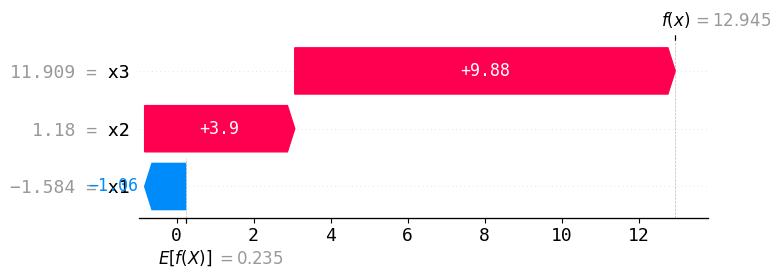

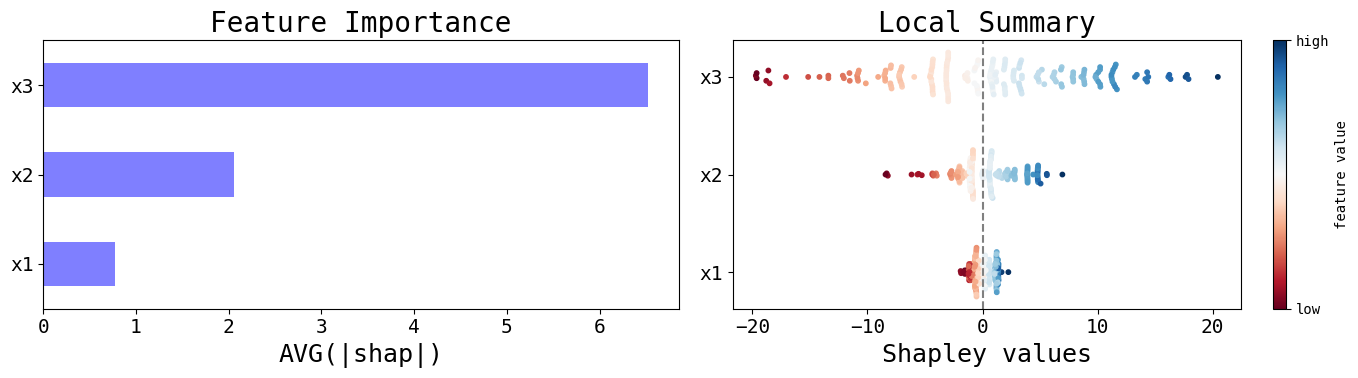

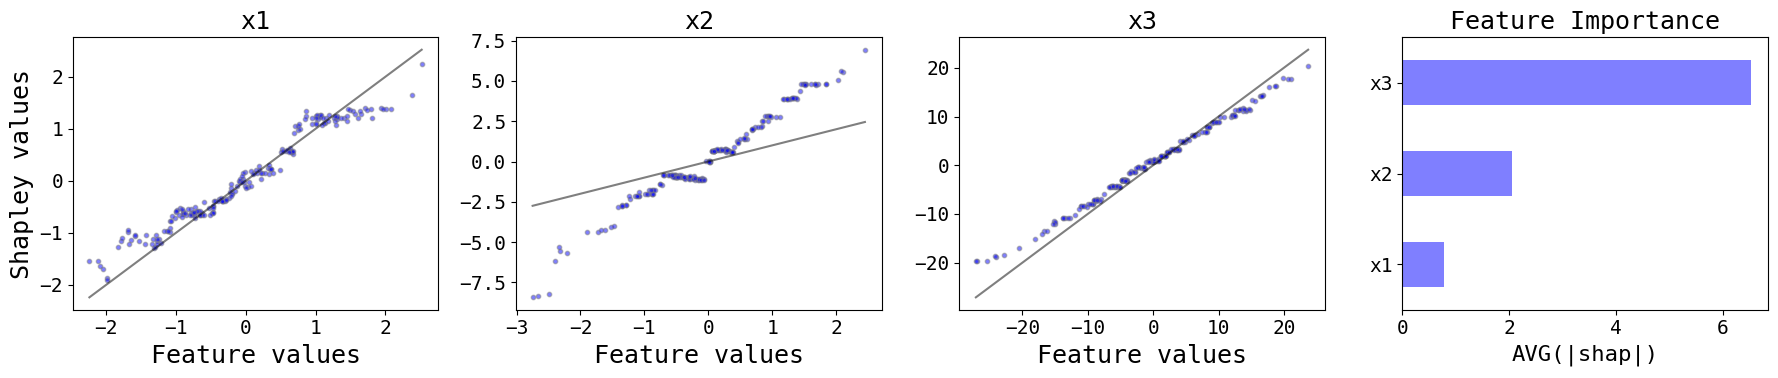

In [20]:
# PARAM(x4)
# y = 1 + 1*x1[N(0,1)] + 1*x2[N(0,1)] + 1*(0+1*x2 +[N(0,1)]) + resid
# Since model is linear: FWL kicks-in and we have net effects only
# We would think that x2 is more important, but no, it's X3
seed = 1000
params0 = {'x0': {'mean':1, 'var':0, 'param':1},
          'x1': {'mean':0, 'var':1, 'param':1},
          'x2': {'mean':0, 'var':1, 'param':1},
          'x3': {'inter': 0, 'slope': 10, 'var_res': 1, 'param':1},  # x3 = 0 + 10*x2 +eps
          'eps': {'mean':0, 'var':2}}

splt = create_shap_explanation(parameters=params0, nobs=nobs, seed=seed, simu_mod=simulate_model_indirect)

## Implementing Shap values

I now code my own implementation.

In [30]:
all_feats = ['x1','x2','x3']
def get_combinations(flist):
  "All combinations of a list of features"
  combinations = []
  for r in range(len(flist) + 1):
      combinations.extend(itertools.combinations(flist, r))
  return combinations

test_gc = get_combinations(flist=all_feats)
test_gc

[(),
 ('x1',),
 ('x2',),
 ('x3',),
 ('x1', 'x2'),
 ('x1', 'x3'),
 ('x2', 'x3'),
 ('x1', 'x2', 'x3')]

In [31]:
test_feat = 'x3'
feats_exc_x = set(all_feats) - set([test_feat])
set_sets_exc_x = get_combinations(flist=feats_exc_x)
set_sets_exc_x

[(), ('x2',), ('x1',), ('x2', 'x1')]

In [23]:
gbr = GradientBoostingRegressor(random_state=1089, max_depth = 2)
gbr.fit(xdf,ydf)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor(max_depth=2, random_state=1089)

In [32]:
def sample_df(xdf, curr_set, test_feat,seed):
  """
  Given a curr_set of features
  - for feat in xdf.columns \ curr_set --> random sample
  - for feat in curr_set --> xdf[feat]
  So: output[curr_set] == xdf[curr_set] should always be true, else RND
  """
  # 1. Get random sample for the complete df
  rnd_cpy = xdf.sample(n=len(xdf), replace=True, random_state=seed)
  rnd_cpy.set_index(xdf.index, inplace=True)
  set_rnd = set(xdf.columns) - set(curr_set)
  for feat in curr_set:
    rnd_cpy[feat] = xdf[feat]


  return rnd_cpy

# test it
curr_set = set(['x2','x1'])
#curr_set = set([])  #empty set--> everything is sampled
test_df =   sample_df(xdf, curr_set, test_feat='x3', seed=10)
np.all(test_df[list(curr_set)].values == xdf[list(curr_set)].values)

True

In [26]:
def compute_shap_values(test_feat, model, xdf, seed,  samples = 100):
  """
  Get the marginal improvement of x wrt reference set
  S: set of all features
  Si: set of all features that exclude i
  Ci: Set of all combinations of elements in Si
  """
  nobs = len(xdf)
  S_set = set(xdf.columns)
  M = len(S_set)
  # Step 1: compute Si
  S_i = S_set - {test_feat}
  C_i = get_combinations(flist=S_i)
  df_value = pd.DataFrame(index=xdf.index, columns = range(len(C_i)))
  np.random.seed(seed)
  # Step 2: compute F(Su{i}) - F(S)
  for i,subS in enumerate(C_i):
    array_simu = np.zeros((nobs, samples))  # initialize array
    seed_array = np.random.choice(int(2*samples), samples)
    for b in range(samples):  # we need to random sample many times!
      ## 1. Start by getting a sampled version of xdf that coincides wih cols in subS
      df_subS_union_i = sample_df(xdf, curr_set=subS, test_feat=test_feat, seed=seed_array[b])
      #  2. Compute F(subS U {xi}) and F(subS)
      # since x_i was randomized by default, I can do the following
      f_subS = model.predict(df_subS_union_i)
      # Now I need to replace the real x_i
      df_subS_union_i[test_feat] = xdf[test_feat]
      f_union = model.predict(df_subS_union_i)
      value_i = f_union - f_subS
      weight_i = 1/math.comb(M-1,len(subS))
      array_simu[:,b] = weight_i * value_i  # save in array
    # average out all of these
    df_value[i] = np.mean(array_simu, axis=1)
  # weighted sum
  shap_values = (1/M) * df_value.sum(axis=1)
  shap_values.rename(test_feat, inplace=True)
  return shap_values

def compute_all_shapley(model, xdf, seed, samples):
  "Get Shapley values for all features in a dataframe"
  all_feats = xdf.columns
  myshaps = pd.DataFrame(index = xdf.index, columns = all_feats)
  for col in all_feats:
    myshaps[col] = compute_shap_values(col, model, xdf, seed)
  return myshaps

# compute for x3
my_shaps_x3 = compute_shap_values(test_feat = 'x3', model=gbr, xdf=xdf, seed=100, samples = 10)
# compute for all vars
my_shaps_all = compute_all_shapley(model=gbr, xdf=xdf, seed=100, samples = 100)
my_shaps_all.head()

,x1,x2,x3
0,0.217413,-1.529374,-0.389391
1,-0.548956,0.440352,-0.010766
2,-1.387873,1.853753,-0.142475
3,1.602748,1.979902,-0.031524
4,0.869355,0.463358,0.880089


In [27]:
# Run SHAP
explainer = shap.TreeExplainer(gbr, xdf)
shap_results = explainer(xdf)
shap_values = shap_results.values


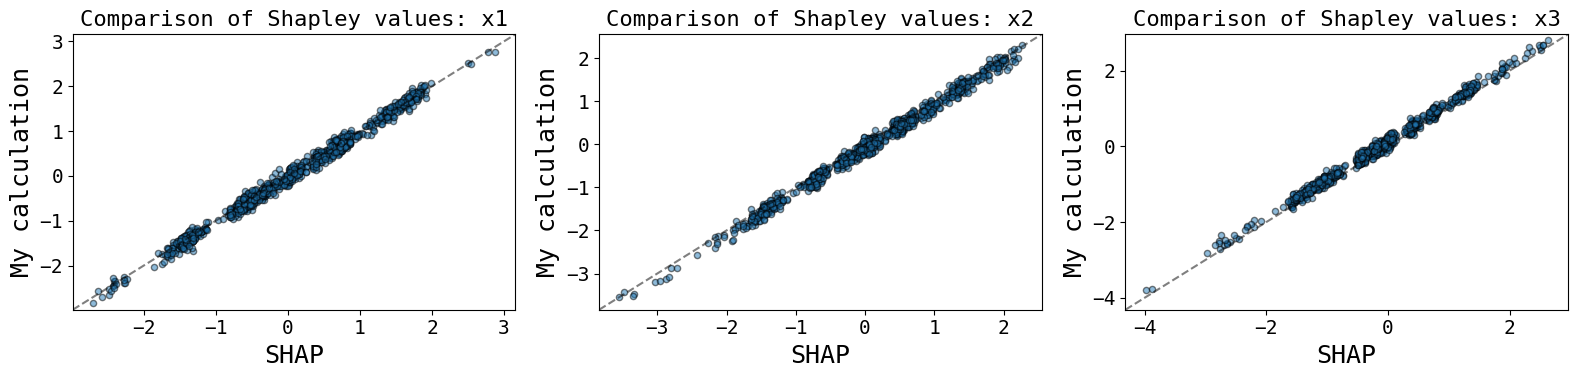

In [28]:
# Compare with my own
fig, ax = plt.subplots(1,3, figsize=(16,4))
for i, col in enumerate(xdf.columns):
  ax[i].scatter(shap_values[:,i], my_shaps_all[col].values, s=20, edgecolor='k', alpha=0.5)
  ax[i].set_title(f'Comparison of Shapley values: {col}', fontsize=16)
  ax[i].set_xlabel('SHAP')
  ax[i].set_ylabel('My calculation')
  xi = ax[i].get_xlim()
  ax[i].plot(xi,xi, color='k', alpha=0.5, ls='--')
  ax[i].set_xlim(xi)
  ax[i].set_ylim(xi)